# DCGAN: Deep Convolutional GAN

In this lab you are going to code a Deep Convolutional GAN (DCGAN), aka a GAN made of convolutions. As we are trying to generate images, convolutions are the perfect layer to use.

This lab is quite RAM & GPU intensive, thus we recommand you to run in a Google Colab.

In [1]:
WORK_ON_COLAB = True

if WORK_ON_COLAB:
  try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
  except Exception:
    pass

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
tf.__version__

'2.1.0-rc1'

## Data

We are download our grayscale dataset (it could be either MNIST or Fashion-MNIST). Note that we are resizing images to a larger scale to match the original paper.

In [0]:
(images, labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
from skimage.transform import resize

images = resize(images, (images.shape[0], 64, 64, 1), preserve_range=True).astype("float32")
images = (images - 127.5) / 127.5

images.shape

(60000, 64, 64, 1)

In [0]:
data_generator = tf.data.Dataset.from_tensor_slices(
    images).shuffle(60000).batch(100, drop_remainder=True)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

def display(images, row=2, col=10):
    fig = plt.figure(figsize=(20, 3))
    it = 0
    for r in range(row):
        for c in range(col):
            ax = plt.subplot(row, col, it + 1)
            ax.set_axis_off()
            ax.imshow(images[it, :, :, 0] * 127.5 + 127.5, cmap='gray')
            it += 1
    return fig

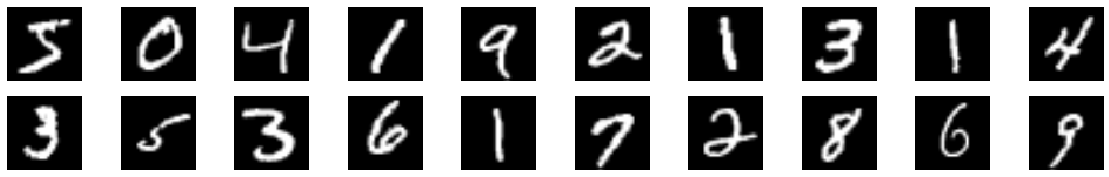

In [7]:
display(images);

# Exercice

Code the generator and the discriminator:

### 1. Generator:

- Input noise of (1, 1, 100)
- Transpose convolution of 1024 channels, kernel of 4, stride 1 and valid padding; followed by a BatchNorm and a LeakyReLU of 0.2
- Transpose convolution with kernel of 4, stride 2 and same padding; followed by a BatchNorm and a LeakyReLU of 0.2. All of this line repeated 3 times with 512, 256, and 128 channels respectively.
- A final transpose convolution with a kernel of 4, a stride of 2, a same padding.

Questions: Which activation for the last conv? How many channels?

### 2. Discriminator:

- Image input
- Four block of Conv (kernel 4, stride 2, padding same) + BatchNorm + LeakyReLU with respectively 128, 256, 512, and 1024 channels.

Questions: What additional layer is needed to have a scalar output? Which activation to use?

In [0]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Flatten, Input
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model


def get_generator():
    input_noise = Input(shape=(1, 1, 100))

    x = Conv2DTranspose(1024, kernel_size=4, strides=1, padding="valid")(input_noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(512, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(256, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", activation="tanh")(x)

    return Model(inputs=input_noise, outputs=x)


def get_discriminator():
    input_image = Input(shape=(64, 64, 1))

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(input_image)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
    x = Flatten()(x)

    return Model(inputs=input_image, outputs=x)

generator = get_generator()
discriminator = get_discriminator()

Now that our models are created, a sanity check must be done on the output dimension.

In [10]:
import numpy as np

def get_noise(batch_size, nz=100):
    return tf.random.normal([batch_size, 1, 1, nz])

noise = get_noise(20)

print("init", noise.shape)
fake_images = generator(noise)
print("Fake images", fake_images.shape)  # Should be (_, 64, 64, 1)
preds = discriminator(fake_images)
print("Predictions", preds.shape)  # Should be (_, 1)

init (20, 1, 1, 100)
Fake images (20, 64, 64, 1)
Predictions (20, 1)


In [0]:
# generator.summary()
# discriminator.summary()

Two losses are needed:

1. The discriminator must classify original images as real and generated images as fake.
2. The generator must force the discriminator to classify its generated images as real.

Fill the following losses:

In [0]:
from tensorflow.keras.losses import binary_crossentropy

def discriminator_loss(preds_real, preds_fake):
    loss_real = binary_crossentropy(tf.ones_like(preds_real), preds_real, from_logits=True)
    loss_fake = binary_crossentropy(tf.zeros_like(preds_fake), preds_fake, from_logits=True)
    return loss_real + loss_fake


def generator_loss(preds_fake):
    return binary_crossentropy(tf.ones_like(preds_fake), preds_fake, from_logits=True)

We create two optimizers, one for the discriminator and one for the generator. Remember that Adam keeps variables about the model, and thus cannot be shared as a SGD could.

In [0]:
from tensorflow.keras.optimizers import Adam

optimizer_d = Adam(learning_rate=1e-4, beta_1=0.5)
optimizer_g = Adam(learning_rate=1e-4, beta_1=0.5)

We define our train step for a single batch. Fill the missing part.

Note that we use the decorator `tf.function` to "compile" the function and speed up a bit the training. This decorator should always be placed on top of computationaly intensive functions.

In [0]:
@tf.function
def train_step(images):
    noise = get_noise(images.shape[0])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer_g.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    optimizer_d.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, gen_loss

We can now train our DCGAN.

Monitor the losses of our model. Beware that one doesn't converge to 0 while the other diverge. It would be mean that the "adverserial" part of the training is biased in favor of one of the model.

Base noise:


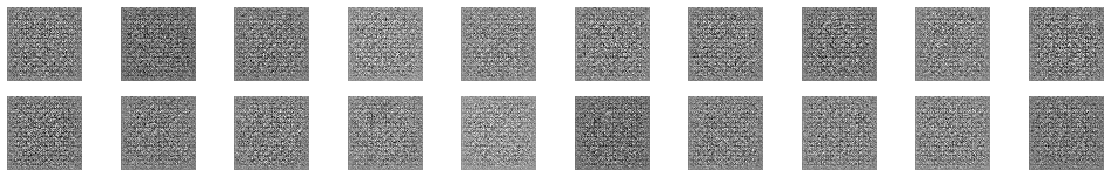

====== Epoch  0 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.4786030650138855, Generator: 5.168595790863037


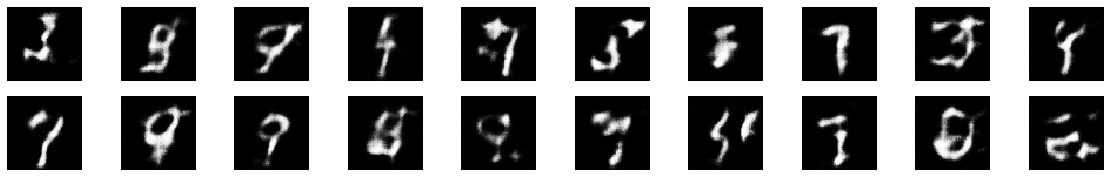

====== Epoch  1 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.4876248240470886, Generator: 2.9606661796569824


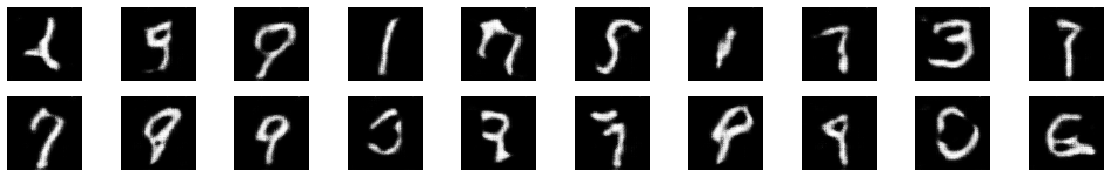

====== Epoch  2 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.4462273120880127, Generator: 3.0399672985076904


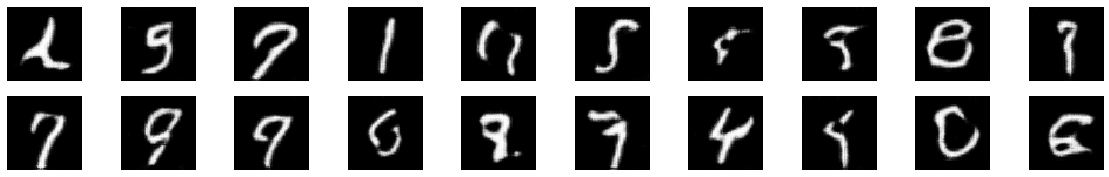

====== Epoch  3 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.3929280936717987, Generator: 3.503840923309326


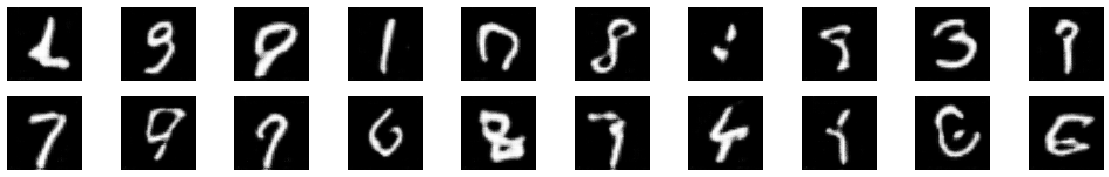

====== Epoch  4 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.24137373268604279, Generator: 4.099499225616455


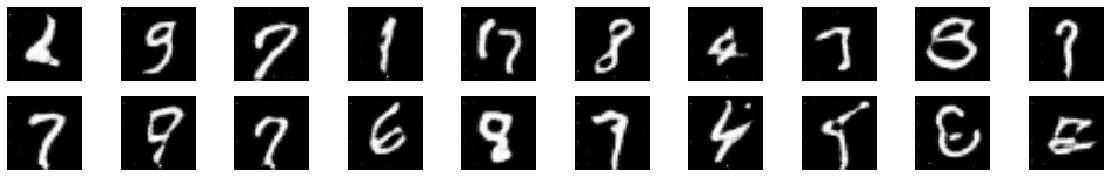

====== Epoch  5 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.5583713054656982, Generator: 3.237457036972046


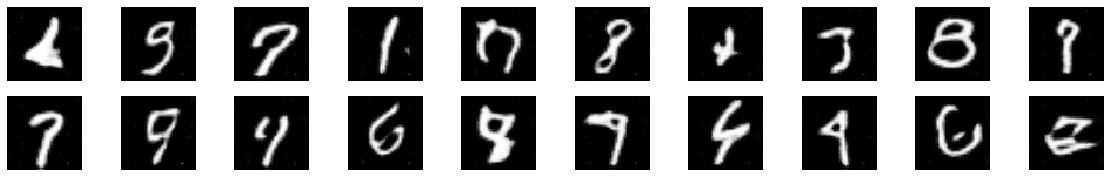

====== Epoch  6 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.3487876057624817, Generator: 3.8014731407165527


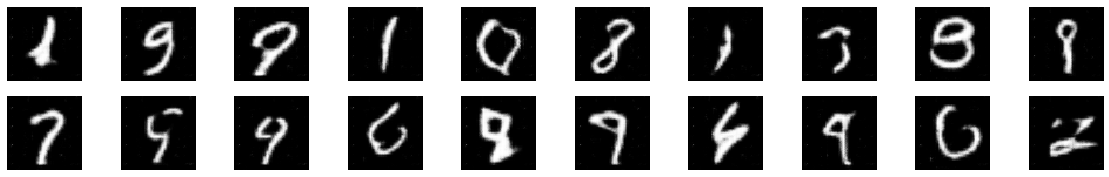

====== Epoch  7 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.33307182788848877, Generator: 3.9503493309020996


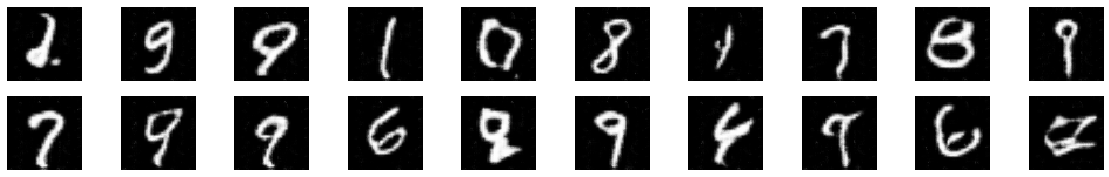

====== Epoch  8 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.29243534803390503, Generator: 3.9895596504211426


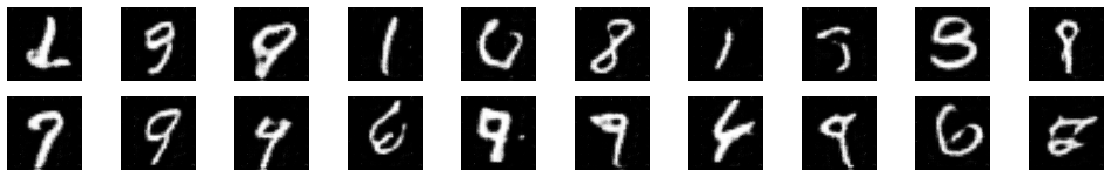

====== Epoch  9 ======
50 ... 100 ... 150 ... 200 ... 250 ... 300 ... 350 ... 400 ... 450 ... 500 ... 550 ... 
Discriminator: 0.1485026329755783, Generator: 5.0309576988220215


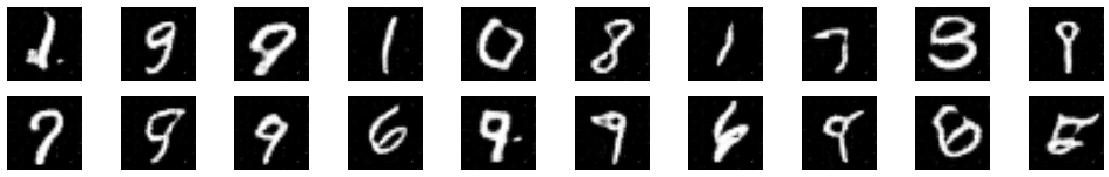

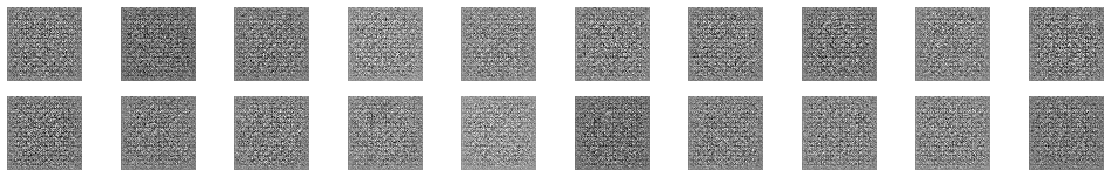

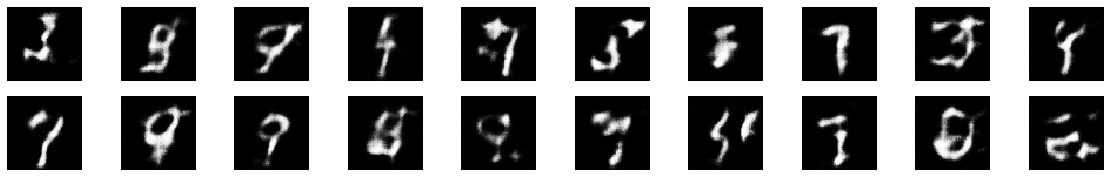

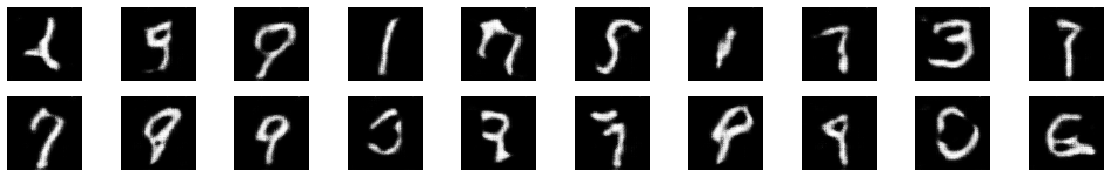

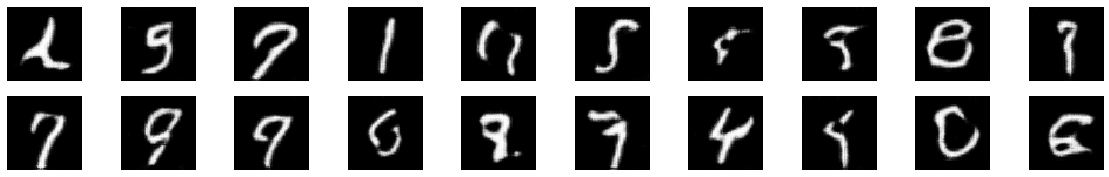

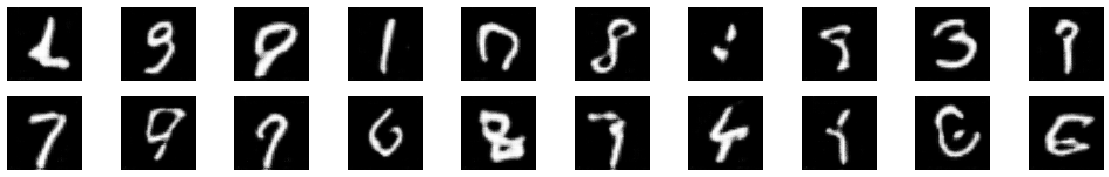

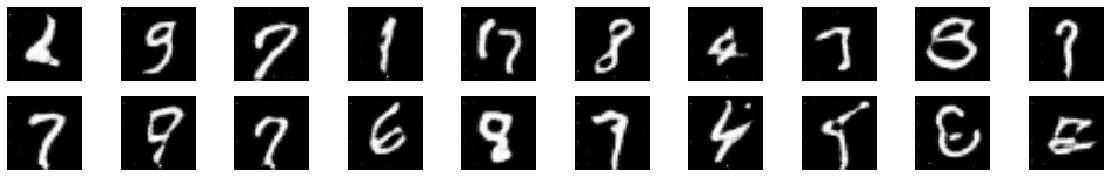

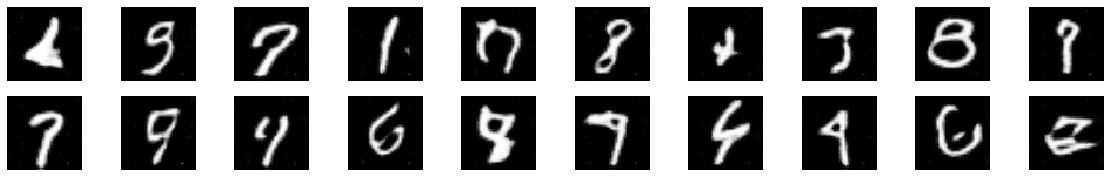

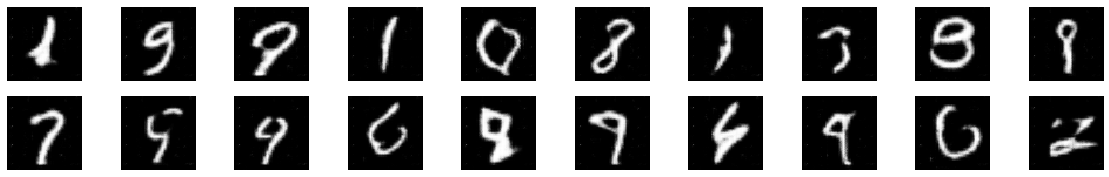

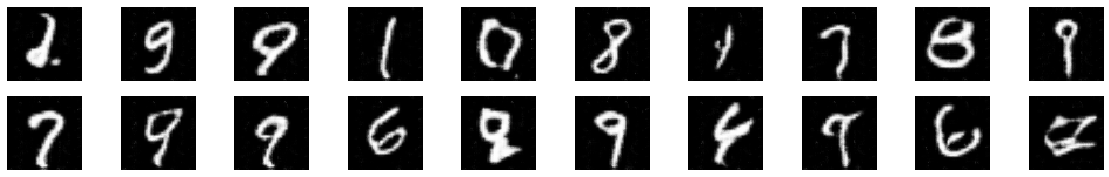

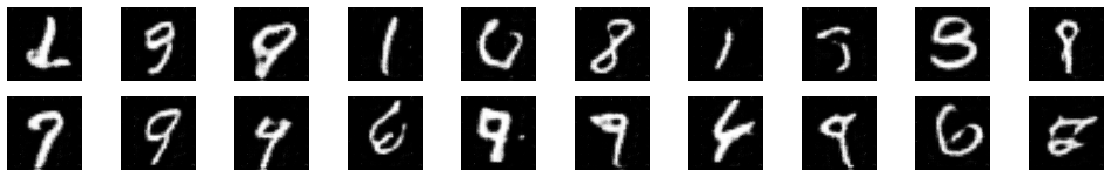

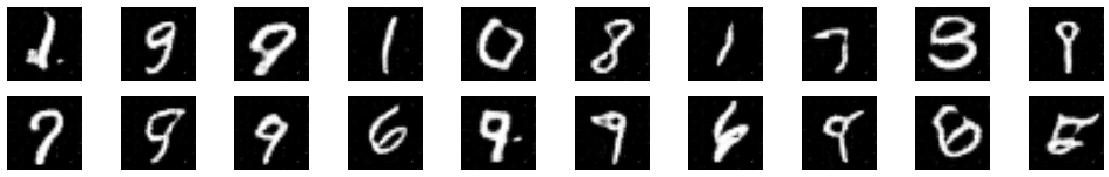

In [21]:
from tensorflow.keras.metrics import Mean
from IPython.core.display import display as jupy_display
import numpy as np

epochs = 10

fixed_noise = get_noise(20)

print("Base noise:")
fake_images = generator(fixed_noise, training=False).numpy()
jupy_display(display(fake_images))

for epoch in range(epochs):
    print("====== Epoch {:2d} ======".format(epoch))

    epoch_loss_d = Mean()
    epoch_loss_g = Mean()
    
    epoch_len = tf.data.experimental.cardinality(data_generator)
    for i, real_images in enumerate(data_generator):
        loss_d, loss_g = train_step(real_images)
        epoch_loss_d(loss_d)
        epoch_loss_g(loss_g)
        
        if i % 50 == 0 and i > 0:
            print(i, end=" ... ")
            
    print("\nDiscriminator: {}, Generator: {}".format(
        epoch_loss_d.result(), epoch_loss_g.result()))
    fake_images = generator(fixed_noise, training=False).numpy()
    jupy_display(display(fake_images))

# Homework

- Try more epochs to have crisper images.
- Try other datasets, like celeba. Beware of the number of channels.
- Modify this network to make a cDCGAN.